In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


def compute_form_factor(x_um, y, pad_factor=10):
    """
    Compute form factor power spectrum |F(k)|^2 with zero-padding
    to increase frequency-domain resolution.

    pad_factor = how many times to extend array length via zero-padding.
    """

    # ---- Normalize ----
    y_norm = y / np.trapezoid(y, x_um)

    # ---- Zero padding ----
    N = len(y_norm)
    Np = pad_factor * N               # padded size
    y_pad = np.zeros(Np)
    y_pad[:N] = y_norm                # add zeros to the end

    # ---- FFT ----
    Y = np.fft.fft(y_pad)

    # ---- Spatial step and k axis ----
    dx = x_um[1] - x_um[0]            # um
    k = np.fft.fftfreq(Np, d=dx) * 2 * np.pi   # 1/um

    # ---- Form factor power spectrum ----
    F2 = np.abs(Y)**2                 # |F|^2

    return k[:Np//2], F2[:Np//2]


def k_to_THz(k):
    """
    Convert wavenumber k (1/um) to frequency in THz.
    """
    c = 3e8
    k_m = k * 1e6
    return (c * k_m / (2*np.pi)) / 1e12


def plot_bunch_and_form_factor(x_um, y, f_cut_THz=100, pad_factor=10):
    """
    Plot bunch profile and |F|^2 with zero-padding to boost resolution.
    """

    # ---- Bunch profile ----
    plt.figure(figsize=(8,4))
    plt.plot(x_um, y)
    plt.xlabel("x (um)")
    plt.ylabel("Intensity")
    plt.title("Bunch Profile")
    plt.grid()
    plt.show()

    # ---- Compute form factor with padding ----
    k, F2 = compute_form_factor(x_um, y, pad_factor=pad_factor)

    # ---- Convert to frequency ----
    freq_THz = k_to_THz(k)

    # ---- Frequency truncation ----
    mask = (freq_THz >= 0) & (freq_THz <= f_cut_THz)

    # ---- Plot ----
    plt.figure(figsize=(8,4))
    plt.plot(freq_THz[mask], F2[mask])
    plt.xlabel("Frequency (THz)")
    plt.ylabel("|F(f)|²")
    plt.title(f"Form Factor |F|² (Zero-padding ×{pad_factor}) 0–{f_cut_THz} THz")
    plt.grid()
    plt.show()

# ========== reasmple ==========
def resample_to_fixed_length(x, y, out_len=1024):
    x_new = np.linspace(x.min(), x.max(), out_len)
    y_new = np.interp(x_new, x, y)
    return x_new, y_new

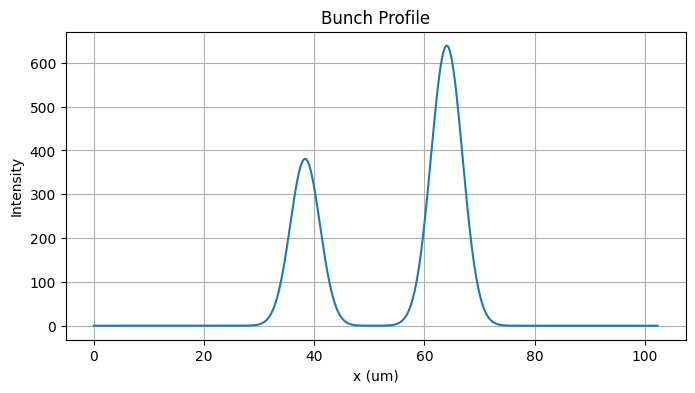

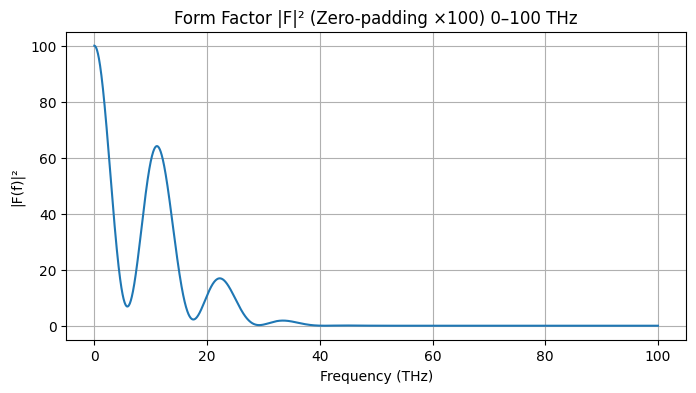

In [ ]:
# ==== CSV path ====
csv_path = "./generated_beam_profile/G2RP_100_800_2_5_1_3_20_40_05_3_30000/G2RP_29991_Q1_380.632_s1_2.690_Q2_638.937_s2_2.853_ratioc_0.596_d_25.71.csv"
# =======================

# read CSV
df = pd.read_csv(csv_path)
x_um = df["x_um"].values
y    = df["Intensity"].values

# call function
plot_bunch_and_form_factor(x_um, y, f_cut_THz=100, pad_factor=100)


In [3]:
input_folder  = "./generated_beam_profile/G2RPL_pt_100_800_2_5_1_3_20_40_05_3_100000/"
output_folder = "./calculated_form_factor/G2RPL_pt_100_800_2_5_1_3_20_40_05_3_100000/"

os.makedirs(output_folder, exist_ok=True)

csv_files = [f for f in os.listdir(input_folder) if f.endswith(".pt")]
print(f"Found {len(csv_files)} input PT files.")


for fname in csv_files:
    
    input_path = os.path.join(input_folder, fname)
    # print(f"\nProcessing {fname}")

    # ---- read bunch profile ----
    # df = pd.read_csv(input_path)
    sample = torch.load(input_path)

    # x_um = df["x_um"].values
    # y    = df["Intensity"].values
    x_um = sample["x_um"].cpu().numpy()
    y    = sample["Intensity"].cpu().numpy()


    # ---- calculate form factor ----
    k, F2 = compute_form_factor(x_um, y, pad_factor=100)
    freq_THz = k_to_THz(k)

    # ---- choose freq range ----
    mask = (freq_THz >= 0) & (freq_THz <= 40)
    freq_THz = freq_THz[mask]
    F2 = F2[mask]

    # ---- resample to 256 points ----
    freq_r, F2_r = resample_to_fixed_length(freq_THz, F2, out_len=256)

    # ---- save CSV ----
    # output_path = os.path.join(output_folder, fname.replace(".csv", "_FF.csv"))
    #df_out = pd.DataFrame({
    #     "freq_THz": freq_r,
    #     "F2": F2_r
    # })
    # df_out.to_csv(output_path, index=False)

    # ---- convert to tensor (float32) ----
    freq_r = torch.tensor(freq_r, dtype=torch.float32)
    F2_r   = torch.tensor(F2_r, dtype=torch.float32)

    # ---- assemble dict for saving ----
    out_dict = {
        "freq_THz": freq_r,
        "F2": F2_r
    }

    # ---- output filename ----
    output_path = os.path.join(output_folder, fname.replace(".pt", "_FF.pt"))
    
    # ---- save .pt ----
    torch.save(out_dict, output_path)



    # print(f"Saved: {output_path}")

print("\nAll files processed and saved!")


Found 100000 input PT files.

All files processed and saved!
